In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine_path = 'data/hawaii.sqlite'
engine = create_engine(f'sqlite:///{engine_path}')

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date

('2017-08-23')

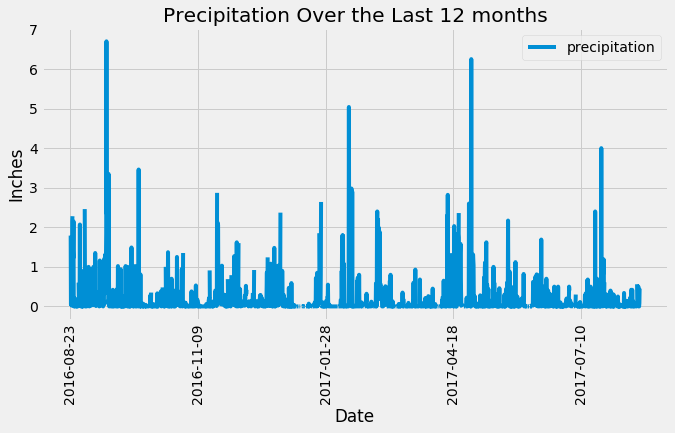

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
date = most_recent_date[0].split('-')

# Calculate the date one year from the last date in data set.
query_date = dt.date(int(date[0]), int(date[1]), int(date[2])) - dt.timedelta(days=365)

# Perform a query to retrieve the date and precipitation scores
ltm_prcp = session.query(Measurement.date, Measurement.prcp).\
           filter(Measurement.date >= query_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(ltm_prcp, columns=['date', 'precipitation']).set_index('date')

# Sort the dataframe by date
prcp_df = prcp_df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(kind='line', xlabel='Date', ylabel='Inches',
             title='Precipitation Over the Last 12 months',
             rot=90, figsize=(10,5))

plt.legend(loc='upper right')
plt.show()

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
session.query(Station.station).distinct().count()

9

There are in total 9 stations in the dataset.

In [13]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
msr_count_by_station = session.query(Station.id, Station.station, func.count(Measurement.id)).\
                       filter(Measurement.station == Station.station).\
                       group_by(Station.id, Station.station).\
                       order_by(func.count(Measurement.id).desc()).all()
msr_count_by_station

[(7, 'USC00519281', 2772),
 (1, 'USC00519397', 2724),
 (2, 'USC00513117', 2709),
 (6, 'USC00519523', 2669),
 (9, 'USC00516128', 2612),
 (3, 'USC00514830', 2202),
 (8, 'USC00511918', 1979),
 (4, 'USC00517948', 1372),
 (5, 'USC00518838', 511)]

According to the above query, the most active station (the one that has the most measurements or highest number of observations) is station "USC00519281" with an id of 7.

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [Station.id,
       Station.station,
       func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)
]

results = session.query(*sel).filter(Measurement.station == Station.station).\
                              filter(Station.id == msr_count_by_station[0][0]).\
                              group_by(Station.id, Station.station).all()

print(f'''
The most active station is: Station {results[0][0]}, {results[0][1]}
Lowest temperature measured: {results[0][2]}
Highest temperature measured: {results[0][3]}
Average temperature: {round(results[0][4], 1)}
''')


The most active station is: Station 7, USC00519281
Lowest temperature measured: 54.0
Highest temperature measured: 85.0
Average temperature: 71.7



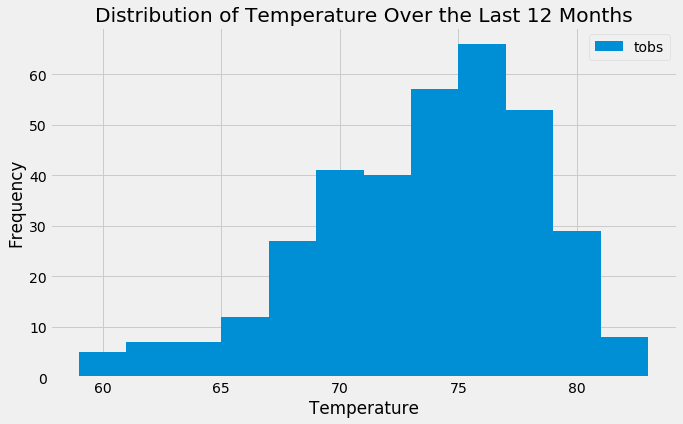

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
ltm_tobs_active = session.query(Measurement.tobs).\
                          filter(Measurement.date >= query_date).\
                          filter(Measurement.station == msr_count_by_station[0][1]).all()

tobs_df = pd.DataFrame(ltm_tobs_active, columns=['tobs'])

# Use Pandas Plotting with Matplotlib to plot the data
tobs_df.plot(kind='hist', ylabel='Frequency',
             title='Distribution of Temperature Over the Last 12 Months',
             bins=12, figsize=(10,6))

plt.xlabel('Temperature')
plt.legend(loc='upper right')
plt.show()

# Close session

In [16]:
# Close Session
session.close()